# Current Trends in Bioinformatics Software Development and Archiving

### Import libraries

In [170]:
import json
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import requests
import xmltodict

%reload_ext autoreload
%autoreload 2
import pbmd_tools as pbmd

In [172]:
%load_ext watermark
%watermark --python --machine
# Python packages versions
%watermark --packages jupyterlab --iversions --watermark
# conda environment name
%watermark --conda

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 5.19.0-43-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

jupyterlab: 3.5.3

matplotlib: 3.7.1
pandas    : 1.5.3
re        : 2.2.1
json      : 2.0.9
numpy     : 1.23.5
requests  : 2.28.2
xmltodict : 0.12.0

Watermark: 2.3.1

conda environment: bioinfosoft



### Import tokens

In [11]:
pbmd.read_tokens()
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN")
PUBMED_TOKEN = os.environ.get("PUBMED_TOKEN")

## 1. PubMed API Entrez Interactions

First of all we are going to explore PubMed in order to find out how many publications for each among 5 forges are there.

In [191]:
queries_github = []
queries_gitlab = []
queries_sourceforge = []
queries_googlecode = []
queries_bitbucket = []

#creating queries for every forge and every year
for year in range(2009, 2023):
    queries_github.append(f'((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_gitlab.append(f'((https://gitlab[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_sourceforge.append(f'((sourceforge.net[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_googlecode.append(f'((googlecode) AND ("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_bitbucket.append(f'((bitbucket.org[Title/Abstract]) AND ("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [192]:
#dictionaries for stocking the number of articles for each forge for each year
#example: {'2009': 0, '2010': 5, '2011': 15, ... }

PMIDs = []
PMIDs_all = []

stats_github = pbmd.get_forges_stat(queries_github, PMIDs)
stats_gitlab = pbmd.get_forges_stat(queries_gitlab, PMIDs_all)
stats_sourceforge = pbmd.get_forges_stat(queries_sourceforge, PMIDs_all)
stats_googlecode = pbmd.get_forges_stat(queries_googlecode, PMIDs_all)
stats_bitbucket = pbmd.get_forges_stat(queries_bitbucket, PMIDs_all)

print(f"\n{len(PMIDs)} articles with 'github.com' found in PubMed")

#checking that there is no duplicates
PMIDs = list(set(PMIDs))
print(f"\n{len(PMIDs)} unique articles with 'github.com' found in PubMed")

100%|██████████| 14/14 [00:19<00:00,  1.38s/it]


10858 articles with 'github.com' found in PubMed

10858 unique articles with 'github.com' found in PubMed


In [194]:
#saving the statistics to reuse it in another notebook

with open("PMIDs.txt", "w") as f:
    for PMID in PMIDs:
        f.write(str(PMID)+"\n")
with open("stats_github.json", "w") as f:
    json.dump(stats_github, f)
with open("stats_gitlab.json", "w") as f:
    json.dump(stats_gitlab, f)
with open("stats_sourceforge.json", "w") as f:
    json.dump(stats_sourceforge, f)    
with open("stats_googlecode.json", "w") as f:
    json.dump(stats_googlecode, f)
with open("stats_bitbucket.json", "w") as f:
    json.dump(stats_bitbucket, f)

In [230]:
# https://pubmed.ncbi.nlm.nih.gov/26262258/ - No DOI in PubMed although there is one in the full text of the article (not from ArXiv), and there are a lot of them
# https://pubmed.ncbi.nlm.nih.gov/28269829/ - they give a wrong link https://github.com/SBU-BMI/imageboxs://github.com/SBU-BMI/imagebox but if you use this link :
# https://github.com/SBU-BMI/imagebox it works. Yet, i am not sure that it is actually what we are looking for since they also provide another link to github.io 
# (also incorect) and i think it's more likely that their code is there
# PMID = 36789260 - 2 links
# https://github.com/tyqGitHub/TYQ/tree/master/GACNNMDA - ????
# https://github.com/mofradlab - ?????? (PMID 36786404)
# PMID = 26124555 - a space in the link
# PMID = 24324759, 22151646 - no space after link
# PMID = 23849037 - why + in the end ?
# PMID = 36315552 - super smart

Next we will use API PubMed to gather the information about each article such as the publication date, the doi, the abstract, the title of the article and the journal. We will then analyse this information.

In [101]:
results = []

In [131]:
#API Pubmed rate limit is 10 request per second with a token and 3 request par second without it

#count = 0
for PMID in tqdm(PMIDs):
    #count += 1
    #if count % 10 == 0:
    #    time.sleep(1)
    
    try:
        summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
        abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
        pubdate = pbmd.get_pubdate_from_summary(summary, "status.txt")
        title = pbmd.get_title_from_summary(summary, "status.txt")
        journal = pbmd.get_journal_from_summary(summary, "status.txt")
        doi = pbmd.get_doi_from_summary(summary, "status.txt")
    except:
        try:
            summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
            abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
            pubdate = pbmd.get_pubdate_from_summary(summary, "status.txt")
            title = pbmd.get_title_from_summary(summary, "status.txt")
            journal = pbmd.get_journal_from_summary(summary, "status.txt")
            doi = pbmd.get_doi_from_summary(summary, "status.txt")
        except:
            continue
        
    #checking in case the API is bugging 
    if (pubdate, doi) == (None, None):
        time.sleep(2)
        summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
        abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
        pubdate = pbmd.get_pubdate_from_summary(summary, "status.txt")
        title = pbmd.get_title_from_summary(summary, "status.txt")
        journal = pbmd.get_journal_from_summary(summary, "status.txt")
        doi = pbmd.get_doi_from_summary(summary, "status.txt")     

    results.append((PMID, pubdate, doi, journal, title, abstract))

100%|██████████| 59/59 [01:40<00:00,  1.70s/it]


In [141]:
df = pd.DataFrame.from_records(results)
df = df.rename(columns = {0: 'PMID', 1: 'PubDate', 3: 'DOI', 4: 'Journal', 5: 'Title', 6: 'Abstract'})
df = df.drop_duplicates(subset = 'PMID')
df = df.reset_index(drop = True)

In [142]:
len(df)

10880

In [149]:
print(f"Number of records without publication date is: {len(df[df['PubDate'].isnull()])}")

Number of records without publication date is: 59


In [20]:
df = df.drop(df.columns[-2:], axis=1)

In [22]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 2. Geting links from the obtained data using regex

In [88]:
df = pd.read_csv('articles.tsv', sep='\t')

In [89]:
df['GitHub_link_raw'] = df['Abstract'].astype(str).apply(pbmd.get_link_from_abstract)
df['GitHub_link_clean'] = df['GitHub_link_raw'].astype(str).apply(pbmd.clean_link)
df['GitHub_owner'] = df['GitHub_link_clean'].apply(pbmd.get_owner_from_link)
df['GitHub_repo'] = df['GitHub_link_clean'].apply(pbmd.get_repo_from_link)

In [90]:
print(f"Number of records with weird abstracts leading to inability to extract a link: {len(df[df['GitHub_owner'].isna()])}")

Number of records with weird abstracts leading to inability to extract a link: 6


In [91]:
print(f"Number of records without a repository name: {len(df[df['GitHub_repo'].isna()])-len(df[df['GitHub_owner'].isna()])}")

Number of records without a repository name: 251


In [164]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 3. GitHub API Interactions

In [4]:
df = pd.read_csv('articles.tsv', sep='\t')

In [111]:
PMIDs = df['PMID'][df['GitHub_repo'].notna()].to_list()
len(PMIDs)

10623

In [113]:
for PMID in tqdm(PMIDs):

    with open("gitstat.txt", "a") as f:
        f.write(f"\n\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['GitHub_link_clean'].values[0]}")

    info = pbmd.get_repo_info(df[df['PMID']==PMID]['GitHub_owner'].values[0], df[df['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")

    if info["status"]: 
        idx = df.index[df['PMID'] == PMID][0]

        df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
        df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
        df.loc[idx, "Fork"] = pbmd.is_fork(info)
    else:
        
        time.sleep(3600)
        
        info = pbmd.get_repo_info(df[df['PMID']==PMID]['GitHub_owner'].values[0], df[df['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")
        idx = df.index[df['PMID'] == PMID][0]
        df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
        df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
        df.loc[idx, "Fork"] = pbmd.is_fork(info)

100%|██████████| 905/905 [05:39<00:00,  2.67it/s]


In [ ]:
PMIDs = df['PMID'][df['Repo_created_at'].isna()].to_list()
len(PMIDs)

758

In [115]:
df.to_csv('articles.tsv', sep='\t', index=False)

## 4. Software Heritage API interactions

In [74]:
df = pd.read_csv('articles.tsv', sep='\t')

In [5]:
PMIDs = df['PMID'][df['GitHub_owner'].notna()].to_list()
len(PMIDs)

10847

In [6]:
for PMID in tqdm(PMIDs):
    
    try:
        info = pbmd.check_is_in_softwh(df[df['PMID']==PMID]['GitHub_link_clean'].values[0])
    except:
        try:
            info = pbmd.check_is_in_softwh(df[df['PMID']==PMID]['GitHub_link_clean'].values[0])
        except:
            continue

    idx = df.index[df['PMID'] == PMID][0]

    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|██████████| 10847/10847 [19:47<00:00,  9.13it/s]  


In [57]:
df.to_csv('articles.tsv', sep='\t', index=False)

## Unresolved links analysis

In [ ]:
df1 = pd.read_csv('no_info2.tsv', sep='\t',usecols=['PMID', 'PubDate', 'DOI', 'Journal', 'Title', 'Abstract', 'Issue', 'GitHub_link_clean','Correct_link'])

In [384]:
print(f"Number of articles with a wrong link (either a space in the link, or no space after link, etc) : {len(df1[df1['Issue'] == 'wrong link'])}") 

Number of articles with a wrong link (either a space in the link, or no space after link, etc) : 58


In [385]:
print(f"Number of articles with a renamed repository : {len(df1[df1['Issue'] == 'renamed'])}") 

Number of articles with a renamed repository : 11


In [386]:
print(f"Number of articles with a deleted repository : {len(df1[df1['Issue'] == 'owner deleted']) + len(df1[df1['Issue'] == 'repo deleted'])}")

Number of articles with a deleted repository : 146


Resolving unresolved but existing links

In [387]:
df1.loc[df['Correct_link'].notna(),'GitHub_owner'] = df1.loc[df['Correct_link'].notna(),'Correct_link'].apply(pbmd.get_owner_from_link)
df1.loc[df['Correct_link'].notna(),'GitHub_repo'] = df1.loc[df['Correct_link'].notna(),'Correct_link'].apply(pbmd.get_repo_from_link)

df1.loc[df['Correct_link'].isna(),'GitHub_owner'] = df1.loc[df['Correct_link'].isna(),'GitHub_link_clean'].apply(pbmd.get_owner_from_link)
df1.loc[df['Correct_link'].isna(),'GitHub_repo'] = df1.loc[df['Correct_link'].isna(),'GitHub_link_clean'].apply(pbmd.get_repo_from_link)

In [389]:
PMIDs = df1['PMID'][df1['GitHub_repo'].notna()].to_list()
len(PMIDs)

215

In [390]:
count = 0
for PMID in tqdm(PMIDs):
    count += 1
    if count % 5000 == 0:
        time.sleep(3600)
    
    with open("gitstat.txt", "a") as f:
        f.write(f"\n\n PMID: {PMID}, GitHub link: {df1[df1['PMID'] == PMID]['Correct_link'].values[0]}")

    info = pbmd.get_repo_info(df1[df1['PMID']==PMID]['GitHub_owner'].values[0], df1[df1['PMID']==PMID]['GitHub_repo'].values[0], GITHUB_TOKEN, "gitstat.txt")

    idx = df1.index[df['PMID'] == PMID][0]

    df1.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
    df1.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
    df1.loc[idx, "Fork"] = pbmd.is_fork(info)

100%|████████████████████████████████████████████████████████████████████████████████| 215/215 [01:05<00:00,  3.30it/s]


In [391]:
PMIDs = df1['PMID'][df1['Correct_link'].notna()].to_list()
len(PMIDs)

69

In [392]:
for PMID in tqdm(PMIDs):
    
    info = pbmd.check_is_in_softwh(df1[df1['PMID']==PMID]['Correct_link'].values[0])

    idx = df1.index[df1['PMID'] == PMID][0]
    
    df1.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df1.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:13<00:00,  5.03it/s]


In [393]:
PMIDs = df1['PMID'][df1['Correct_link'].isna()].to_list()
len(PMIDs)

146

In [394]:
for PMID in tqdm(PMIDs):
    
    info = pbmd.check_is_in_softwh(df1[df1['PMID']==PMID]['GitHub_link_clean'].values[0])

    idx = df1.index[df1['PMID'] == PMID][0]
    
    df1.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df1.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [00:56<00:00,  2.60it/s]


In [396]:
print(f"Repositories that are forks : {len(df1[df1['Fork'] == 1])}")

Repositories that are forks : 0


In [397]:
print(f"Not in SoftWH : {len(df1[df1['In_SoftWH'] == 0])}")

Not in SoftWH : 118


In [398]:
print(f"In SoftWH : {len(df1[df1['In_SoftWH'] == 1])}")

In SoftWH : 97


In [401]:
print(f"Were deleted but archived in SoftWH : {len(df1[df1['Correct_link'].isna()][df1['In_SoftWH'] == 1])}")

Were deleted but archived in SoftWH : 49


C:\Users\nadia\AppData\Local\Temp\ipykernel_9668\3996960915.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Were deleted but archived in SoftWH : {len(df[df['Correct_link'].isna()][df['In_SoftWH'] == 1])}")


## Last commit analysis

In [48]:
def get_last_commit_files(owner, repo, access_token):
    
    headers = {'Authorization': f"Token {access_token}"}   
    url = f'https://api.github.com/repos/{owner}/{repo}/commits'
    response = requests.get(url, headers=headers)
    data = response.json()
    if response.status_code == 200:
        if len(data) > 0:
            last_commit_sha = data[0]['sha']
            files_url = f'{url}/{last_commit_sha}'
            files_response = requests.get(files_url)
            files_data = files_response.json()
            if files_response.status_code == 200:
                files_changed = [file['filename'] for file in files_data['files']]
                return files_changed
        
    return None


In [49]:
owner = 'guilledufort'
repo = 'RENANO'

files_changed = get_last_commit_files(owner, repo, GITHUB_TOKEN)
if files_changed:
    print('Files changed in the last commit:\n')
    for file in files_changed:
        print(file)

Files changed in the last commit:

README.md
renano/main.cpp


In [9]:
df = pd.read_csv('articles.tsv', sep='\t')
PMIDs = df['PMID'][df['GitHub_repo'].notna()].to_list()
len(PMIDs)

10623

In [15]:
for PMID in tqdm(PMIDs[:100]):

    #with open("gitstat.txt", "a") as f:
    #    f.write(f"\n\n PMID: {PMID}, GitHub link: {df[df['PMID'] == PMID]['GitHub_link_clean'].values[0]}")
    
    last_commit_files = ''
    files = get_last_commit_files(df[df['PMID']==PMID]['GitHub_owner'].values[0], df[df['PMID']==PMID]['GitHub_repo'].values[0])
    for file in files:
        last_commit_files += f"{file}, "
        
    idx = df.index[df['PMID'] == PMID][0]

    df.loc[idx, "Last_commit"] = last_commit_files

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


In [18]:
df[df['Last_commit']=="['README.md']"]

,PMID,PubDate,DOI,Journal,Title,Abstract,GitHub_link_raw,GitHub_link_clean,GitHub_owner,GitHub_repo,Repo_created_at,Repo_updated_at,Fork,In_SoftWH,Archived,Last_commit
2,34337657,2021-11-05,10.1093/bib/bbab288,Briefings in bioinformatics,iDeepSubMito: identification of protein submit...,Mitochondria are membrane-bound organelles con...,github.com/houzl3416/iDeepSubMito.,https://github.com/houzl3416/iDeepSubMito/,houzl3416,iDeepSubMito,2021-04-12,2022-09-02,0.0,0.0,NaN,['README.md']
7,32172688,2020-03-16,10.1186/s41065-020-00120-6,Hereditas,STRsearch: a new pipeline for targeted profili...,"[OrderedDict([('@Label', 'BACKGROUND'), ('@Nlm...",github.com/AnJingwd/STRsearch.,https://github.com/AnJingwd/STRsearch/,AnJingwd,STRsearch,2019-10-12,2022-06-22,0.0,1.0,2020-08-11,['README.md']
8,35354136,2022-04-11,10.1088/1361-6560/ac628a,Physics in medicine and biology,Category guided attention network for brain tu...,. Magnetic resonance imaging (MRI) has been wi...,github.com/delugewalker/CGA-U-Net.,https://github.com/delugewalker/CGA-U-Net/,delugewalker,CGA-U-Net,2022-02-09,2022-07-20,0.0,0.0,NaN,['README.md']
9,31173946,2019-05-10,10.1016/j.omtn.2019.04.025,Molecular therapy. Nucleic acids,ACP-DL: A Deep Learning Long Short-Term Memory...,"Cancer is a well-known killer of human beings,...",github.com/haichengyi/ACP-DL.,https://github.com/haichengyi/ACP-DL/,haichengyi,ACP-DL,2018-08-29,2023-03-12,0.0,1.0,2020-03-27,['README.md']
17,35510918,2022-05-05,10.1021/acs.analchem.2c00500,Analytical chemistry,2 Global Tracking of Transformation Products o...,Stable isotope-assisted metabolomics (SIAM) en...,github.com/kechen1984/2H-SIAM,https://github.com/kechen1984/2H-SIAM/,kechen1984,2H-SIAM,2021-09-17,2022-03-26,0.0,0.0,NaN,['README.md']


# A large-scale analysis of bioinformatics code on GitHub
### DOI: 10.1371/journal.pone.0205898

In [51]:
df = pd.read_csv("file.csv")

In [62]:
len(set(df['repo_name'].to_list()))

2782

In [63]:
df['GitHub_owner'] = df['repo_name'].apply(lambda x: x.split('/')[0])
df['GitHub_repo'] = df['repo_name'].apply(lambda x: x.split('/')[1])

In [77]:
for num in tqdm(df[df['Repo_created_at'].isna()]['Unnamed: 0'].to_list()):

    info = pbmd.get_repo_info(df[df['Unnamed: 0']==num]['GitHub_owner'].values[0], df[df['Unnamed: 0']==num]['GitHub_repo'].values[0], GITHUB_TOKEN, "stat.txt")

    if info["status"]: 
        idx = df.index[df['Unnamed: 0']==num][0]

        df.loc[idx, "Repo_created_at"] = pbmd.get_repo_date_created(info)
        df.loc[idx, "Repo_updated_at"] = pbmd.get_repo_date_updated(info)
        df.loc[idx, "Fork"] = pbmd.is_fork(info)


100%|████████████████████████████████████████████████████████████████████████████████| 358/358 [02:00<00:00,  2.97it/s]


In [67]:
df['GitHub_link']= df['repo_name'].apply(lambda x: 'https://github.com/' + str(x) + '/')

In [70]:
for num in tqdm(range(2559, len(df))):

    info = pbmd.check_is_in_softwh(df[df['Unnamed: 0']==num]['GitHub_link'].values[0])

    idx = df.index[df['Unnamed: 0']==num][0]

    df.loc[idx, "In_SoftWH"] = pbmd.is_in_softwh(info)
    df.loc[idx, "Archived"] = pbmd.get_date_archived(info)

100%|████████████████████████████████████████████████████████████████████████████████| 629/629 [01:55<00:00,  5.45it/s]


In [82]:
len(set(df[df['In_SoftWH'] == 1][df['use_repo'] == 1]['repo_name'].to_list()))

C:\Users\nadia\AppData\Local\Temp\ipykernel_19672\3869437448.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['In_SoftWH'] == 1][df['use_repo'] == 1]['repo_name'].to_list()))


1631

In [83]:
len(set(df[df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))

C:\Users\nadia\AppData\Local\Temp\ipykernel_19672\1662194807.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))


89

In [85]:
len(set(df[df['Repo_created_at'].isna()][df['use_repo'] == 1]['repo_name'].to_list()))

C:\Users\nadia\AppData\Local\Temp\ipykernel_19672\330393883.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['Repo_created_at'].isna()][df['use_repo'] == 1]['repo_name'].to_list()))


17

In [86]:
len(set(df[df['Repo_created_at'].isna()][df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))

C:\Users\nadia\AppData\Local\Temp\ipykernel_19672\2921510663.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['Repo_created_at'].isna()][df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))
C:\Users\nadia\AppData\Local\Temp\ipykernel_19672\2921510663.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(set(df[df['Repo_created_at'].isna()][df['In_SoftWH'] == 0][df['use_repo'] == 1]['repo_name'].to_list()))


0

In [19]:
df.to_csv('file_info.tsv', sep='\t', index=False)

<ipython-input-137-e2a26010cc49>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(wrapped_labels, rotation=70, ha='right')
<ipython-input-137-e2a26010cc49>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(wrapped_labels, rotation=70, ha='right')


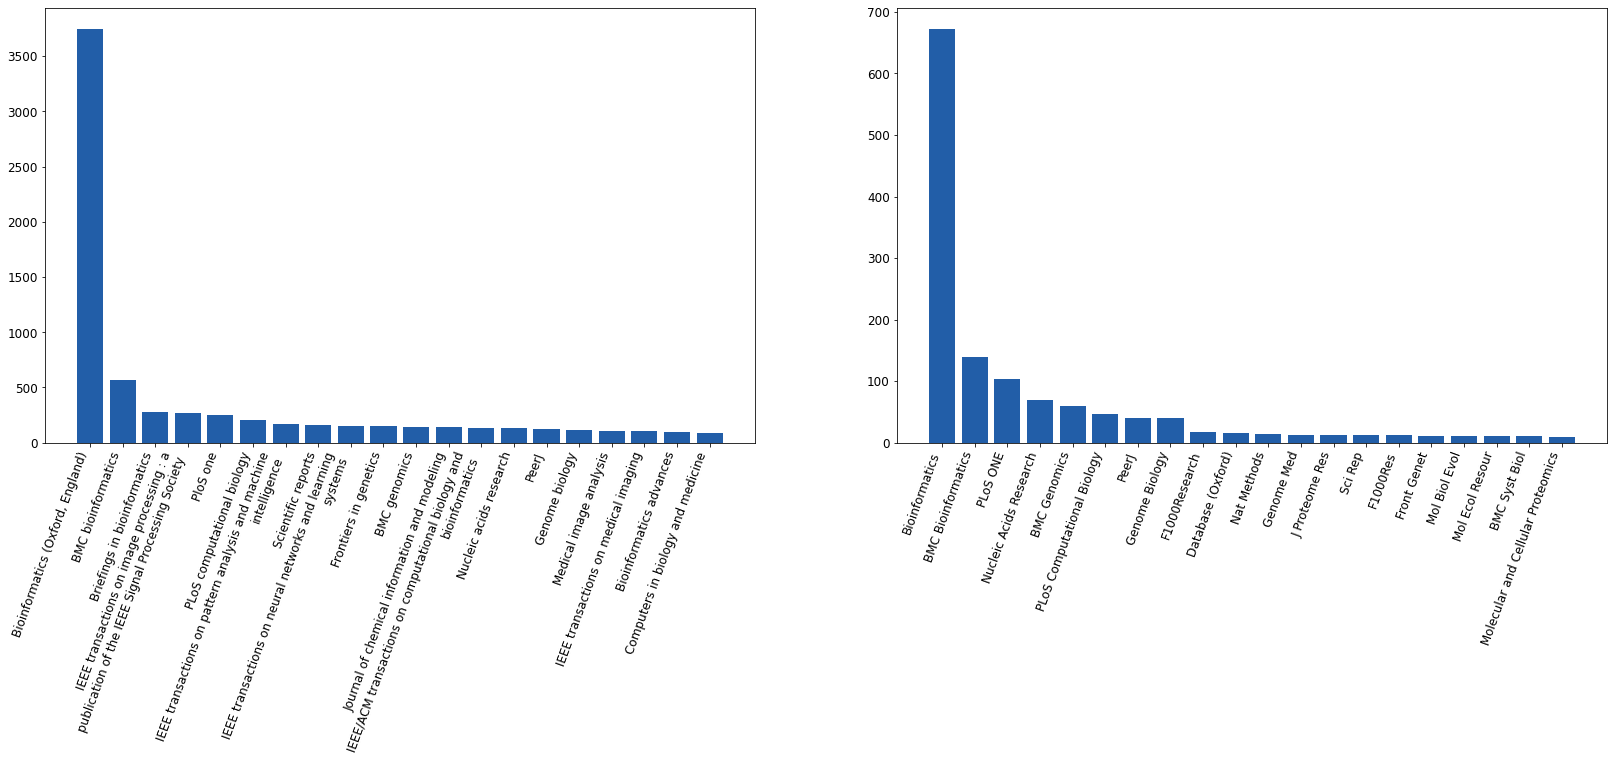

In [137]:
import textwrap

fig, ax = plt.subplots(1,2, figsize=(28, 8))

df = pd.read_csv('articles.tsv', sep='\t')
journals_article = df['Journal'].value_counts().to_dict()
journals = list(journals_article.keys())[:20]
values = list(journals_article.values())[:20]
wrapped_labels = [textwrap.fill(label, 50) for label in journals]

ax[0].bar(journals, values, color='#225ea8')
ax[0].set_xticklabels(wrapped_labels, rotation=70, ha='right')
ax[0].tick_params(axis='y', labelsize=12) 
ax[0].tick_params(axis='x', labelsize=12) 

df = pd.read_csv('file.csv', sep=',')
df.loc[df['journal'] == 'PLoS Comput Biol', 'journal'] = 'PLoS Computational Biology'
df.loc[df['journal'] == 'BMC bioinformatics', 'journal'] = 'BMC Bioinformatics'
df.loc[df['journal'] == 'Nucleic Acids Res', 'journal'] = 'Nucleic Acids Research'
df.loc[df['journal'] == 'Genome Biol', 'journal'] = 'Genome Biology'
df = df[df['use_repo'] == 1]
journals_article = df['journal'].value_counts().to_dict()
journals = list(journals_article.keys())[:20]
values = list(journals_article.values())[:20]
wrapped_labels = [textwrap.fill(label, 50) for label in journals]

ax[1].bar(journals, values, color='#225ea8')
ax[1].set_xticklabels(wrapped_labels, rotation=70, ha='right')
ax[1].tick_params(axis='y', labelsize=12) 
ax[1].tick_params(axis='x', labelsize=12) 


plt.show()



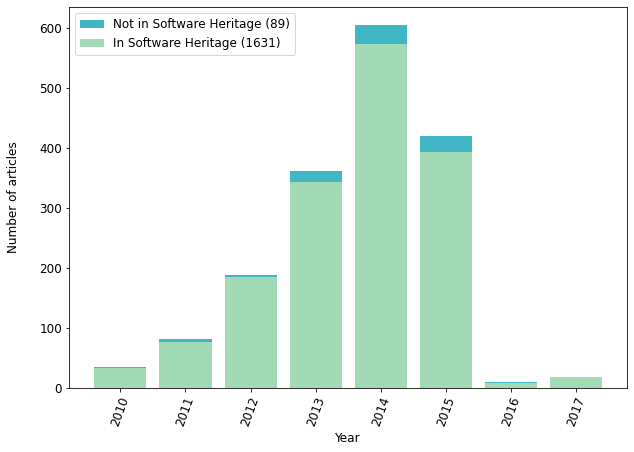

In [121]:
df = pd.read_csv('file_info.tsv', sep='\t')
df = df[df['use_repo'] == 1]

fig, ax = plt.subplots(figsize=(10, 7))

df_grouped = df.groupby([df['year']]).size().reset_index(name='count')
ax.bar(list(set(df['year'].to_list())), df_grouped['count'], color='#41b6c4')

df_grouped = df.groupby([df['year'], 'In_SoftWH']).size().reset_index(name='count')
df_softwh = df_grouped[df_grouped['In_SoftWH'] == 1]

ax.bar(list(set(df['year'].to_list())), df_softwh['count'], color='#a1dab4')

ax.set_xlabel('Year', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.legend([f"Not in Software Heritage ({sum(df_grouped['count']) - sum(df_softwh['count'])})", 
           f"In Software Heritage ({sum(df_softwh['count'])})"], fontsize=12)

plt.xticks(list(set(df['year'].to_list())), rotation=70)
ax.tick_params(axis='y', labelsize=12) 
ax.tick_params(axis='x', labelsize=12) 

plt.show()


# BMC bioinformatics statistics

In [47]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries = []
queries_github = []
queries_forges = []
for year in range(2009, 2023):
    queries.append(f'(("BMC bioinformatics"[Journal])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_github.append(f'(("BMC bioinformatics"[Journal])) AND ((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_forges.append(f'(("BMC bioinformatics"[Journal])) AND ((("//gitlab."[Title/Abstract])) OR (("sourceforge.net"[Title/Abstract])) OR ("googlecode") OR ("bitbucket.org"[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    

In [4]:
def is_software(PMID, access_token, log_file):
    tags = []
    dict = pbmd.get_summary(PMID, access_token, log_file)['PubmedArticleSet']['PubmedArticle']['MedlineCitation']['MeshHeadingList']['MeshHeading']
    try:
        tags.append(dict['DescriptorName']['#text'])
    except:
        for i in dict:
            tags.append(i['DescriptorName']['#text'])
    if 'Software' in tags:
        return 1
    else:
        return 0

In [48]:
stats_forges = {}
PMIDs_forges = []
stats_forges = {}

for query in tqdm(queries_forges):
    nb = 0 #number of articles for this query
    nb_soft = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_forges:
            nb += 1
            PMIDs_forges.append(id)
    #query[38:42] - it is the year of this query
    stats_forges[query[-33:-29]] = nb

100%|██████████| 14/14 [00:08<00:00,  1.56it/s]


In [49]:
stats_in_journal = {}
PMIDs_in_journal = []
stats_soft = {}

for query in tqdm(queries):
    nb = 0 #number of articles for this query
    nb_soft = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_in_journal:
            nb += 1
            PMIDs_in_journal.append(id)
            try:
                nb_soft += is_software(id, PUBMED_TOKEN, "status.txt")
            except:
                #print(id)
                continue
    #query[38:42] - it is the year of this query
    stats_in_journal[query[41:45]] = nb
    stats_soft[query[41:45]] = nb_soft

100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


In [50]:
stats_with_link = {}
stats_soft_with_link = {}
PMIDs_with_link = []

for query in tqdm(queries_github):
    nb = 0 #number of articles for this query
    nb_soft = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_with_link:
            nb += 1
            PMIDs_with_link.append(id)
            try:
                nb_soft += is_software(id, PUBMED_TOKEN, "status.txt")
            except:
                #print(id)
                continue
    #query[38:42] - it is the year of this query
    stats_with_link[query[76:80]] = nb
    stats_soft_with_link[query[76:80]] = nb_soft

100%|██████████| 14/14 [00:08<00:00,  1.59it/s]


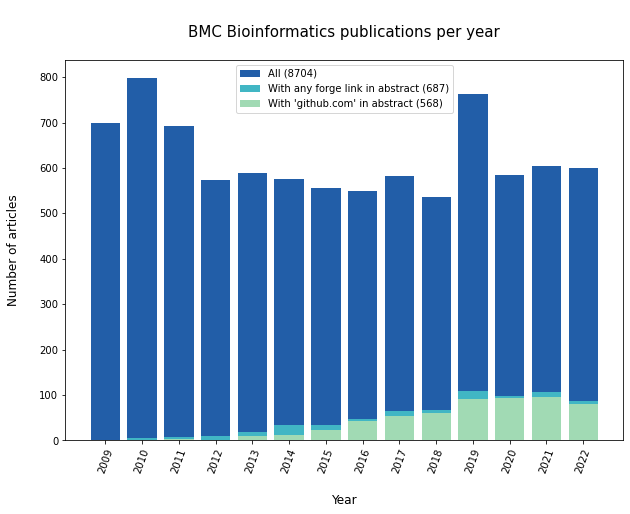

In [51]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2009, 2023))
values_journal = list(stats_in_journal.values())
values_links = list(stats_with_link.values())
values_forges = list(stats_forges.values())

for i in range(14):
    values_forges[i] += values_links[i]

ax.bar(years, values_journal, color='#225ea8')
ax.bar(years, values_forges, color='#41b6c4')
ax.bar(years, values_links, color='#a1dab4')

ax.legend([f"All ({sum(values_journal)})", 
           f"With any forge link in abstract ({sum(values_forges)})",
           f"With 'github.com' in abstract ({sum(values_links)})"], loc = 'upper center')

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('\nBMC Bioinformatics publications per year\n', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.show()

# Bioinformatics statistics

In [163]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries = []
queries_github = []
queries_forges = []
for year in range(2009, 2023):
    queries.append(f'(("Bioinformatics"[Journal])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_github.append(f'(("Bioinformatics"[Journal])) AND ((github.com[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    queries_forges.append(f'(("Bioinformatics"[Journal])) AND ((("gitlab"[Title/Abstract])) OR (("sourceforge.net"[Title/Abstract])) OR ("googlecode") OR ("bitbucket.org"[Title/Abstract])) AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')

In [164]:
stats_in_journal = {}
PMIDs_in_journal = []

for query in tqdm(queries):
    nb = 0 #number of articles for this query
    nb_soft = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_in_journal:
            nb += 1
            PMIDs_in_journal.append(id)
    #query[38:42] - it is the year of this query
    stats_in_journal[query[-33:-29]] = nb

100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


In [165]:
stats_forges = {}
PMIDs_forges = []

for query in tqdm(queries_forges):
    nb = 0 #number of articles for this query
    nb_soft = 0
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_forges:
            nb += 1
            PMIDs_forges.append(id)
    #query[38:42] - it is the year of this query
    stats_forges[query[-33:-29]] = nb

100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


In [166]:
stats_with_link = {}
PMIDs_with_link = []

for query in tqdm(queries_github):
    nb = 0 #number of articles for this query
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_with_link:
            nb += 1
            PMIDs_with_link.append(id)
    #query[38:42] - it is the year of this query
    stats_with_link[query[-33:-29]] = nb

100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


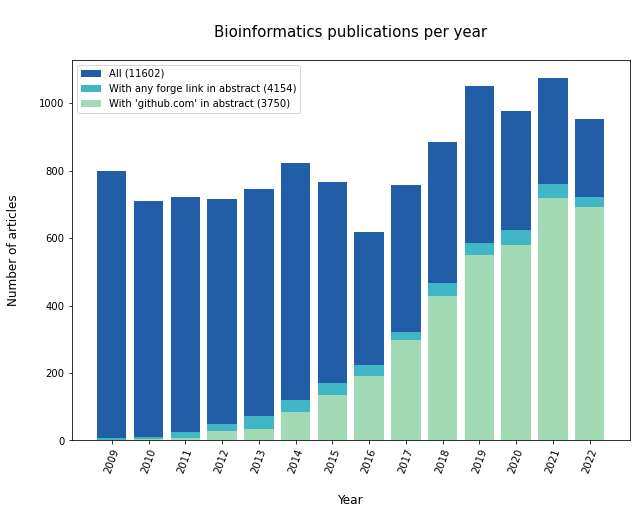

In [168]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2009, 2023))
values_journal = list(stats_in_journal.values())
values_links = list(stats_with_link.values())
values_forges = list(stats_forges.values())

for i in range(14):
    values_forges[i] += values_links[i]

ax.bar(years, values_journal, color='#225ea8')
ax.bar(years, values_forges, color='#41b6c4')
ax.bar(years, values_links, color='#a1dab4')

ax.legend([f"All ({sum(values_journal)})", 
           f"With any forge link in abstract ({sum(values_forges)})",
           f"With 'github.com' in abstract ({sum(values_links)})"], loc = 'upper left')

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('\nBioinformatics publications per year\n', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.show()

# GitLab statistics

In [57]:
db = "pubmed"
domain = "https://www.ncbi.nlm.nih.gov/entrez/eutils"
retmode = "json"
queries_gitlab = []
for year in range(2014, 2023):
    queries_gitlab.append(f'("gitlab") AND (("{year}/01/01"[Date - Publication] : "{year}/12/31"[Date - Publication]))')
    

In [61]:
stats_gitlab = {}
PMIDs_gitlab = {'2014': [], '2015': [], '2016': [],'2017': [],'2018': [],'2019': [], '2020': [],'2021': [],'2022': []}

for query in tqdm(queries_gitlab):
    nb = 0 #number of articles for this query
    queryLinkSearch = f"{domain}/esearch.fcgi?db={db}&retmode={retmode}&retmax=15000&term={query}"
    response = requests.get(queryLinkSearch)
    pubmed_json = response.json()
    for id in pubmed_json["esearchresult"]["idlist"]:
        #checking if there are any dublicates in PubMed IDs (it happens because of the PubDate that can be EPubDate or normal)
        if id not in PMIDs_gitlab:
            nb += 1
            PMIDs_gitlab[query[-33:-29]].append(id)
    #query[38:42] - it is the year of this query
    stats_gitlab[query[-33:-29]] = nb

100%|██████████| 9/9 [00:05<00:00,  1.63it/s]


In [115]:
results = []

for year in tqdm(PMIDs_gitlab):
    
    for PMID in PMIDs_gitlab[year]:
        
        try:

            summary = pbmd.get_summary(PMID, PUBMED_TOKEN, "status.txt")
            abstract = pbmd.get_abstract_from_summary(summary, "status.txt")
            pub_year = year
        
        except:
            
            continue

        results.append((PMID, pub_year, abstract))


100%|██████████| 9/9 [02:19<00:00, 15.51s/it]


In [137]:
df = pd.DataFrame.from_records(results)
df = df.rename(columns = {0: 'PMID', 1: 'pub_year', 2: 'Abstract'})
df = df.drop_duplicates(subset = 'PMID')
df = df.reset_index(drop = True)

In [159]:
df['gitlab_link'] = df['Abstract'].astype(str).apply(pbmd.get_gitlab_link).apply(pbmd.clean_link)
df['is_gitlabcom'] = df['gitlab_link'].apply(pbmd.is_gitlabcom)

In [161]:
stats_gitlabcom = {} 

for year in range(2014, 2023):
    stats_gitlabcom[year] = sum(df[df['pub_year'] == str(year)]['is_gitlabcom'])

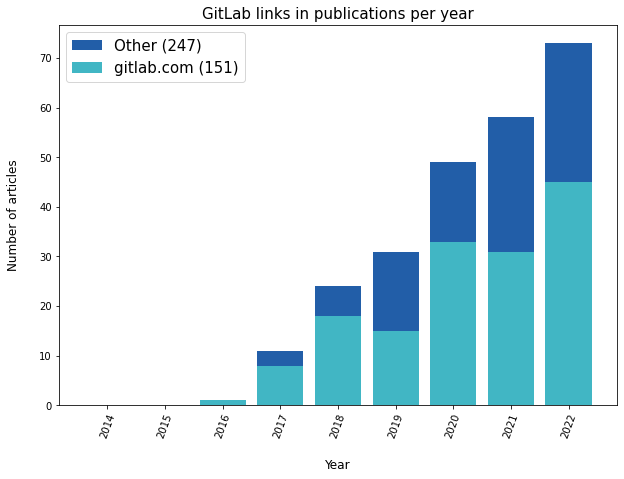

In [162]:
fig, ax = plt.subplots(figsize=(10, 7))

years = list(range(2014, 2023))
values_gitlab = list(stats_gitlab.values())
values_gitlabcom = list(stats_gitlabcom.values())

ax.bar(years, values_gitlab, color='#225ea8')
ax.bar(years, values_gitlabcom, color='#41b6c4')

ax.legend([f"Other ({sum(values_gitlab)})", 
           f"gitlab.com ({sum(values_gitlabcom)})"], loc = 'upper left', fontsize=15)

ax.set_xlabel('\nYear', fontsize=12, fontfamily='sans-serif')
ax.set_ylabel('Number of articles\n', fontsize=12, fontfamily='sans-serif')
ax.set_title('GitLab links in publications per year', fontsize=15, fontfamily='sans-serif')

plt.xticks(years, rotation=70)

plt.show()